In [16]:
# import library
import librosa
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import os
from datetime import datetime 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from keras.utils import to_categorical
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Inputs

In [1]:
# TRAINED MODEL
# model folder
MODEL_FP = 'models/'

# FULL DATA
AUDIO_FP = '../UrbanSound8K/audio/'
DATA_FFP = '../UrbanSound8K/metadata/UrbanSound8K.csv'

# SAMPLE DATA
# audio file path
SAMPLE_AUDIO_FP = 'audio_sample/'

# sample audio spreadsheet name
SAMPLE_AUDIO_FN = 'list_of_sample_audio.xlsx'

# Load stored preprocessed data 

In [3]:
%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
%store -r y2
%store -r LabelEncoder

# Functions
customized functions

CNN require fixed size for all inputs. To overcome this, zero pad the output vectors to make them all the same size

In [10]:
# function used to extract feature from sample audio
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [11]:
# function to plot confusion matrix
# code source: https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data preprocessing

### Data conversion and extract MFCCS from each audio 

In [12]:
# read data
audio_data = pd.read_csv(DATA_FFP)

In [13]:
data = []

for index, row in audio_data.iterrows():
    # audio full file name
    audio_ffn = os.path.join(os.path.abspath(AUDIO_FP),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    # class name, audio, sample rate, mfccs
    class_name = row['class']
    mfccs_data = extract_features(audio_ffn)
    
    # append
    data.append([mfccs_data, class_name])
    
# convert into dataframe
df_audio = pd.DataFrame(data, columns=['feature', 'class_name'])

### Convert data and labels using LabelEncoder
Convert categorical data into numerical

In [17]:
# Convert features and classes into arrays
X = np.array(df_audio.feature.tolist())
y = np.array(df_audio.class_name.tolist())

# Encode the class
LabelEncoder = LabelEncoder()
y2 = to_categorical(LabelEncoder.fit_transform(y)) 

### Split into train test
Split data set into train/test set 80:20

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y2, 
                                                    test_size=0.2, 
                                                    random_state = 40)

In [19]:
x_train.shape

(6985, 40, 174)

In [20]:
y_train.shape

(6985, 10)

In [21]:
x_test.shape

(1747, 40, 174)

In [22]:
y_test.shape

(1747, 10)

# Model architecture: Convolutional Neural Network (CNN)
Construct a Convolutional Neural Network using Keras and Tensorflow

In [24]:
# Construct model and build layer by layer
model = Sequential()

Begin with simple model architecture, which consists of 3 layers:
- Input layer
- Convolutional layer (4x)
- Output layer

**Descriptions:**
1. The convolution layers are designed for feature detection. It works by sliding a filter window over the input and performing a matrix multiplication and storing the result in a feature map. This operation is known as a convolution. 
2. Parameter:
    - filter = the number of nodes in each layer.
    - kernel size = the size of the kernel window, 2 resulting in 2x2 filter matrix 
    
    
**Architecture structure:**
1. **First layer:**: 
    - receive input shape. Each audio contains 40 MFCCs (columns), 174 frames taking padding into account and 1 channel (mono).
    - dropout 20%. Dropout will randomly exclude nodes from each update cycle which resulting in a network have better generalisation and less likely to overfit the training data.
    - Activation function: relu (Rectified Linear Activation), proven to have work well in NN.
4. **Convolutional layer:** 
    - 4 convolutional layer
    - Each convolutional layer has an associated pooling layer (MaxPooling2D)
    - Final convolutional layer is Globel average pooling (GlobalAveragePooling2D).
    - The pooling layer is to reduce the dimensionality of the model which serves to shorten the training time and reduce overfitting.
    - The max pooling type takes the max size for each window.
    - The Global average pooling type takes the average, this is suitable to feed into the dense output layer.
3. **Output layer:**
    - "dense" layer type which is the standard layer type in NN.
    - 10 nodes (total classes).
    - Activation: softmax. This makes the output sum up to 1 so the output can be innterpreted as probabilities. The model will make its prediction  based on which option has the highest probability.

In [23]:
# total number of class
tot_class = y2.shape[1]

# total rows
tot_rows = x_train.shape[1]

# total columns
tot_columns = x_train.shape[2]

# total channels
tot_channels = 1

In [25]:
tot_columns

174

In [39]:
# model architecture
x_train = x_train.reshape(x_train.shape[0], tot_rows, tot_columns, tot_channels)
x_test = x_test.reshape(x_test.shape[0], tot_rows, tot_columns, tot_channels)

filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(tot_rows, tot_columns, tot_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(tot_class, activation='softmax')) 

# Compile the model
Use the following 3 parameters to compile the model:
- Loss function: "Categorical crossentropy". Most common choice for classification. Low score = model is performing better.
- Metrics: "accuracy". Allow to view accuracy score to validate the data.
- Optimizer: "adam", common and generally good optimizer.

In [40]:
# Compile the model
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'], 
              optimizer='adam') 

In [41]:
# Display the model architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 41, 64)        

In [42]:
# show pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]
print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 8.0710%


# Train the model
Train the model.

- epoch (number of times the model will cycle through the data).
- batch size. Large batch size can reduce the generalisation ability of the model
- start with low epoch and batch size. If the model is converging based on the output, increase both numbers
- When the model “converges” there is usually no significant error decrease / performance increase anymore.

In [44]:
# inputs
NUM_EPOCH = 72
NUM_BATCH = 256

# model name
MODEL_NAME = 'cnn_basic_model.hdf5'

checkpointer = ModelCheckpoint(filepath= MODEL_FP + MODEL_NAME, 
                               verbose=1, save_best_only=True)

# begin training
starttime = datetime.now()

# train the model
model.fit(x_train, 
          y_train, 
          batch_size=NUM_BATCH, 
          epochs=NUM_EPOCH, 
          validation_data=(x_test, y_test), 
          callbacks=[checkpointer], verbose=1)

duration = datetime.now() - starttime
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/72
6985/6985 [==============================] - 12s 2ms/step - loss: 0.6638 - accuracy: 0.7794 - val_loss: 0.7987 - val_accuracy: 0.7350

Epoch 00001: val_loss improved from inf to 0.79869, saving model to models/cnn_basic_model.hdf5
Epoch 2/72
6985/6985 [==============================] - 12s 2ms/step - loss: 0.6358 - accuracy: 0.7854 - val_loss: 0.8397 - val_accuracy: 0.7218

Epoch 00002: val_loss did not improve from 0.79869
Epoch 3/72
6985/6985 [==============================] - 12s 2ms/step - loss: 0.6377 - accuracy: 0.7880 - val_loss: 0.7863 - val_accuracy: 0.7361

Epoch 00003: val_loss improved from 0.79869 to 0.78631, saving model to models/cnn_basic_model.hdf5
Epoch 4/72
6985/6985 [==============================] - 12s 2ms/step - loss: 0.6198 - accuracy: 0.7924 - val_loss: 0.7432 - val_accuracy: 0.7630

Epoch 00004: val_loss improved from 0.78631 to 0.74317, saving model to models/cnn_basic_model.hdf5
Epoch 5/72
6985/6985 

# Test the model

In [45]:
# test with testing data
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]
print("Trained model on testing sets accuracy: %.4f%%" % accuracy)

Trained model on testing sets accuracy: 90.9559%


In [46]:
# test with training data
score = model.evaluate(x_train, y_train, verbose=0)
accuracy = 100 * score[1]
print("Trained model on training sets accuracy: %.4f%%" % accuracy)

Trained model on training sets accuracy: 95.7910%


[Observations]
- Pre-training model accuracy is 8%.
- Trained model accuracy is 91%.
- Training sets accuracy is > testing sets accuracy, this indicate that the model has not suffered from overfitting

### Confusion Matrix and Classification Report

In [47]:
# predict the test data using the model
predictions = model.predict(x_test)

In [48]:
# convert array into vector (classes in number)

# get the selected classses in testing data set
val_test = np.zeros((y_test.shape[0],1))
for i in range(val_test.shape[0]):

    # for CATEGORICAL: pick the highest confidence value
    val_test[i] = np.argmax(y_test[i])

# get the predicted classes
val_preds = np.zeros((predictions.shape[0],1))
for i in range(predictions.shape[0]):

    # for CATEGORICAL: pick the highest confidence value
    val_preds[i] = np.argmax(predictions[i])
    

In [49]:
# snippet of predicted class
val_preds

array([[9.],
       [8.],
       [8.],
       ...,
       [4.],
       [7.],
       [3.]])

In [50]:
# define classes
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music
    
class_label = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
          'drilling', 'engine_idling', 'gun_shot', 'jackhammer',
          'siren', 'street_music']

In [51]:
# Evaluate the model: using classification report and confusion matrix
# using classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# show classification report
print(classification_report(val_test, val_preds))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       192
         1.0       0.88      0.96      0.92        77
         2.0       0.78      0.93      0.85       202
         3.0       0.96      0.80      0.87       219
         4.0       0.90      0.90      0.90       185
         5.0       0.90      0.97      0.93       206
         6.0       0.89      0.98      0.93        63
         7.0       0.94      0.95      0.95       196
         8.0       0.95      0.95      0.95       191
         9.0       0.95      0.80      0.87       216

   micro avg       0.91      0.91      0.91      1747
   macro avg       0.91      0.92      0.91      1747
weighted avg       0.91      0.91      0.91      1747



Confusion matrix, without normalization
[[180   1   4   0   1   4   1   1   0   0]
 [  1  74   0   0   2   0   0   0   0   0]
 [  0   1 188   1   0   5   0   2   2   3]
 [  0   4  18 176   6   5   2   1   6   1]
 [  4   0   1   1 167   1   3   6   1   1]
 [  0   1   2   0   0 200   0   0   1   2]
 [  0   0   1   0   0   0  62   0   0   0]
 [  0   0   0   0   8   0   1 187   0   0]
 [  0   0   2   3   1   1   0   0 182   2]
 [  1   3  26   3   1   6   1   2   0 173]]


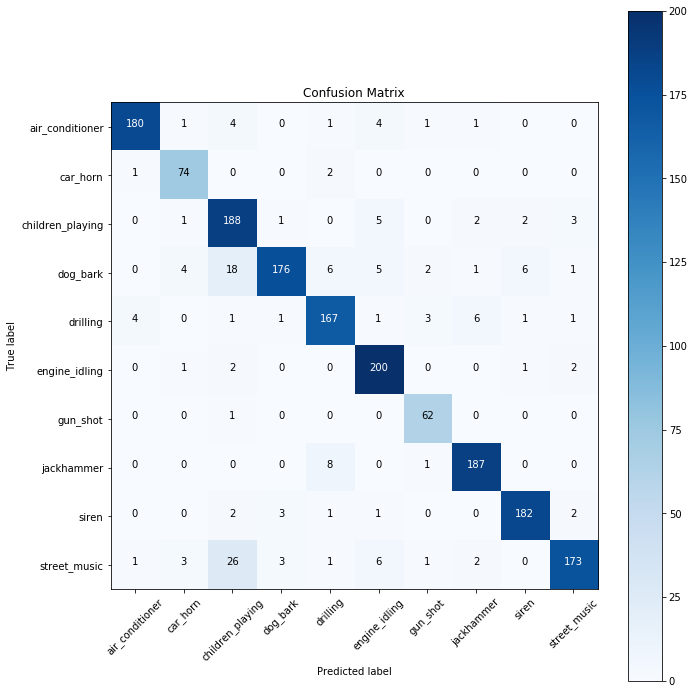

In [52]:
# show confusion matrix
# confusion_matrix(y_true, y_pred)
cm = confusion_matrix(val_test, val_preds)

# plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm=cm, classes=class_label, title='Confusion Matrix' )

# Test the model with sample audio

In [27]:
# load sample audio
list_audio = pd.read_excel(SAMPLE_AUDIO_FP + SAMPLE_AUDIO_FN)
list_audio

,slice_file_name,fsID,start,end,salience,fold,classID,class_name
0,100852-0-0-0.wav,100852,0.000000,4.000000,1,5,0,air_conditioner
1,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn
2,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
3,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
4,103199-4-0-0.wav,103199,0.000000,4.000000,1,3,4,drilling
5,102857-5-0-0.wav,102857,0.000000,4.000000,1,10,5,engine_idling
6,102305-6-0-0.wav,102305,0.000000,2.611610,1,1,6,gun_shot
7,103074-7-0-0.wav,103074,3.341279,7.341279,1,1,7,jackhammer
8,102853-8-0-0.wav,102853,0.000000,4.000000,2,7,8,siren
9,101848-9-0-0.wav,101848,0.000000,4.000000,1,7,9,street_music


The original class is: air_conditioner
The predicted class is: air_conditioner 



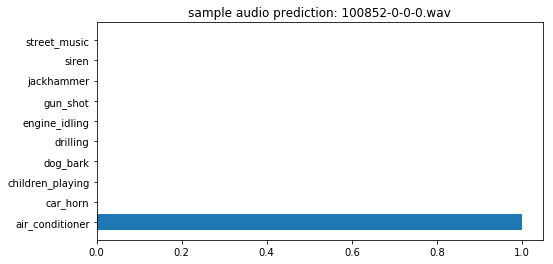



The original class is: car_horn
The predicted class is: car_horn 



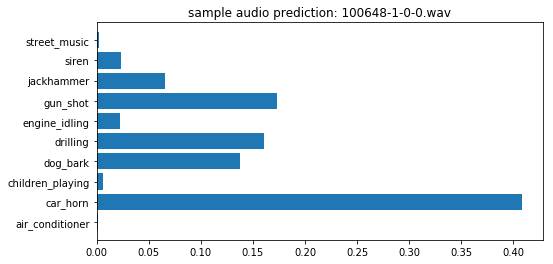



The original class is: children_playing
The predicted class is: children_playing 



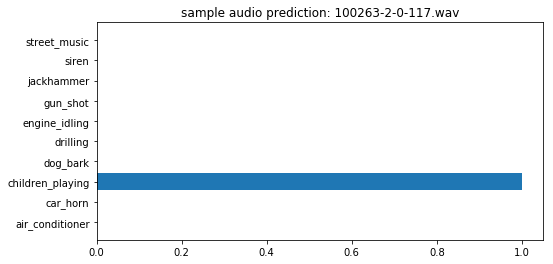



The original class is: dog_bark
The predicted class is: dog_bark 



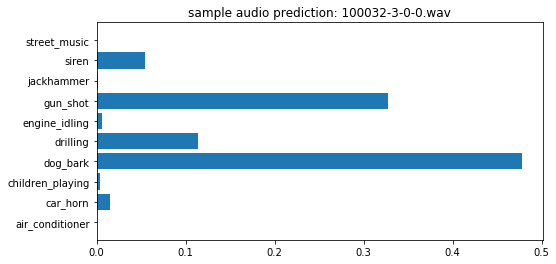



The original class is: drilling
The predicted class is: drilling 



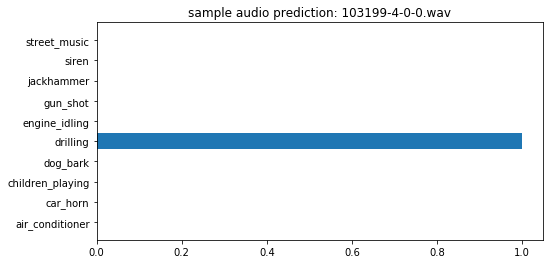



The original class is: engine_idling
The predicted class is: engine_idling 



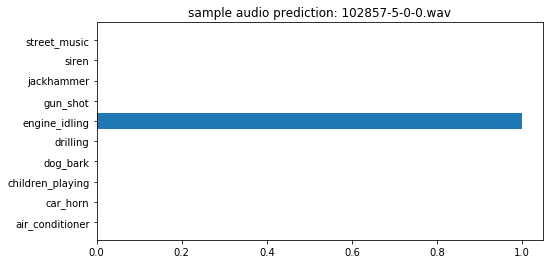



The original class is: gun_shot
The predicted class is: gun_shot 



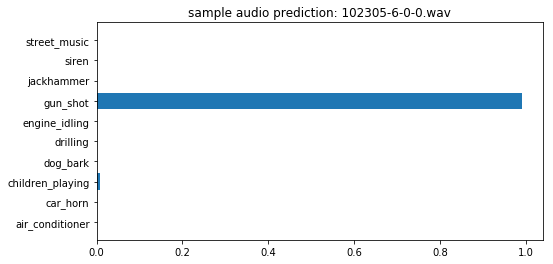



The original class is: jackhammer
The predicted class is: jackhammer 



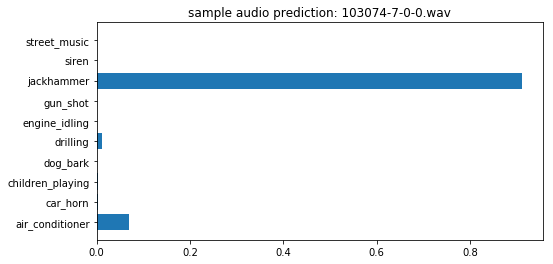



The original class is: siren
The predicted class is: siren 



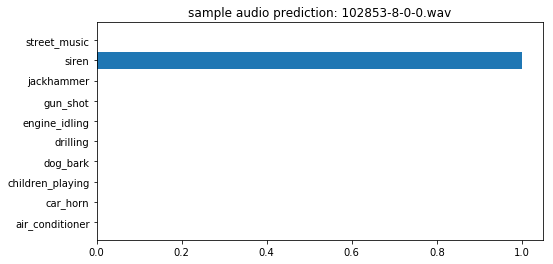



The original class is: street_music
The predicted class is: street_music 



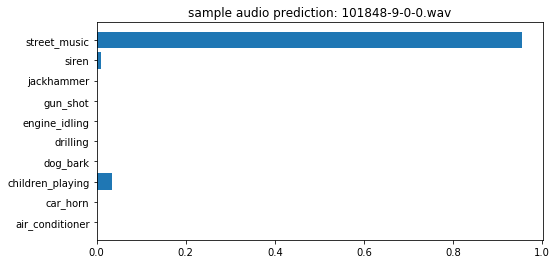

In [60]:
# test all sample audio with the model
for i, row in list_audio.iterrows():
    classname = row['class_name']
    audiofile = row['slice_file_name']
    
    # audio full file name
    audio_ffn = SAMPLE_AUDIO_FP + audiofile
    
    # feature
    feature = extract_features(audio_ffn)
    feature = feature.reshape(1, tot_rows, tot_columns, tot_channels)
    
    # predicted class
    pred_vector = model.predict_classes(feature)
    pred_class = LabelEncoder.inverse_transform(pred_vector) 
    
    # all class prediction probability
    pred_prob_vector = model.predict_proba(feature)
    pred_prob_class = pred_prob_vector[0]
    
    # print out results
    print("The original class is:", classname)
    print("The predicted class is:", pred_class[0], '\n')  
    
    # display all predict probability
    #for i in range(len(pred_prob_class)): 
    #    category = LabelEncoder.inverse_transform(np.array([i]))
    #    print("{:.2%}".format(pred_prob_class[i]), category[0] )
    
    # display all predict probability
    plt.figure(figsize=(8,4))
    plt.barh(class_label, pred_prob_class)
    plt.title("sample audio prediction: {}".format(audiofile))
    plt.show()
    
    print('\n')
